In [1]:
# 오토인코더 : 입력을 그대로 출력하도록 만든 인코더 디코더
# CAE : Convolution AutoEncoder모델 : 합성곱을 이용한 오토인코더로 디노이징에 사용
# 이미지에서 노이즈란 : 데이터에 섞여서 정보를 왜곡하는 의도하지 않은 정보
# 가우시안 노이즈 : 노이즈의 형태가 정규분포의 형태를 따름

In [2]:
# 가우스노이즈 제거모델, 
# 백색잡음 : 가우스노이즈의 특수한 경우 즉 무작위로 섞인 노이즈

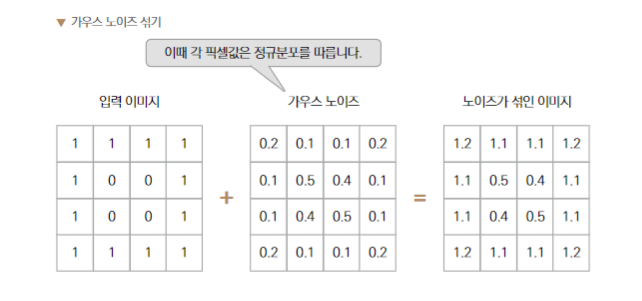

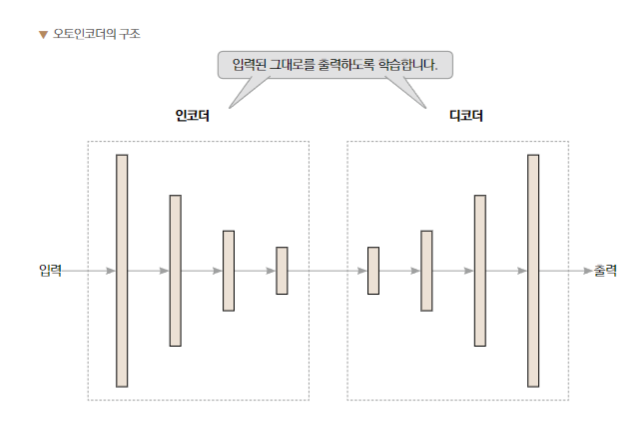

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

In [4]:
# 이미지에 가우스 노이즈를 추가하는 함수
def gaussian_noise(x, scale = 0.8):
  # loc 평균 scale 표준편차
  gaussian_data_x = x + np.random.normal(loc = 0,scale=scale, size=x.shape)
  # 이미지의 픽셀값을 0과 1사이로 정규화
  gaussian_data_x = np.clip(gaussian_data_x,0,1)
  # 파이토치 텐서로 변환
  gaussian_data_x = torch.tensor(gaussian_data_x)
  gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
  return gaussian_data_x

In [5]:
# 학습용 데이터
training_data = MNIST(
    root='./',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = MNIST(
    root='./',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 114473092.04it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53059874.65it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 61403634.88it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20116714.64it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
img = training_data.data[0]
gaussian = gaussian_noise(img)

<ipython-input-4-f557dd71b35c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


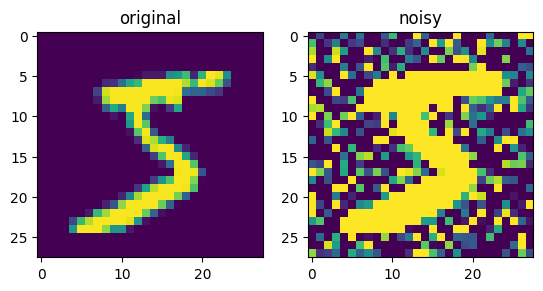

In [7]:
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("noisy")
plt.imshow(gaussian)
plt.show()


In [8]:
# 학습용 torch 데이터셋 만들기
from torch.utils.data.dataset import Dataset
class Denoising(Dataset):
  def __init__(self) -> None:
    # 원본
    self.mnist = MNIST(
      root='./',
      train=True,
      download=True,
      transform=ToTensor()
    )
    # 노이즈가 있는 데이터 리슽
    self.data = []
    # 노이즈 적용
    for i in range(len(self.mnist)):
      noisy_input =  gaussian_noise(self.mnist.data[i])
      input_tensor = torch.tensor(noisy_input)
      self.data.append(torch.unsqueeze(input_tensor,dim=0))
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    data = self.data[index]
    #원본이미지도 0과 1사이로 값을 맞춤
    label = self.mnist.data[index]/255
    return data,label

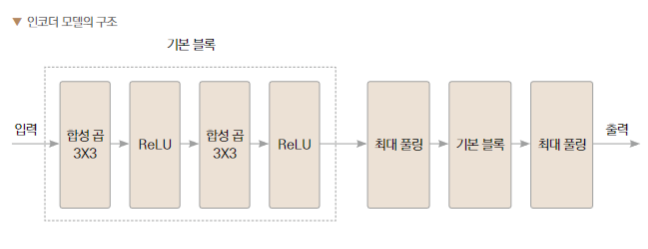

In [9]:
# 기본 블럭
import torch.nn as nn
class BasicBlock(nn.Module):
  def __init__(self,in_channel,out_channel,hidden_dim):
    super(BasicBlock,self).__init__()
    self.conv1 = nn.Conv2d(
        in_channel,
        hidden_dim,
        kernel_size=3,
        padding=1
    )
    self.conv2 = nn.Conv2d(
        hidden_dim,
        out_channel,
        kernel_size=3,
        padding=1
    )
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    return x

In [10]:
# 인코더 모델
class Encorder(nn.Module):
  def __init__(self):
    super(Encorder,self).__init__()
    self.conv1 = BasicBlock(in_channel=1,out_channel=16,hidden_dim=16)
    self.conv2 = BasicBlock(in_channel=16,out_channel=8,hidden_dim=8)
    self.pool = nn.AvgPool2d(kernel_size=2,stride=2)
  def forward(self,x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.pool(x)
    return x

In [11]:
# 디코더
# 기본블록과 업셈플링을 두번 반복나서 합성곱을 진행
# 디코더와 인코더는 대칭적으로 구성

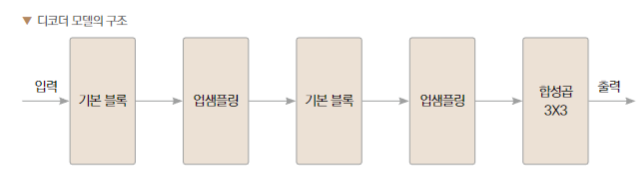

In [12]:
# 디코더는 출력이미지의 픽셀값  활성화 함수를 사용할 수 없음
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.conv1 = BasicBlock(in_channel=8, out_channel=8,hidden_dim=8)
    self.conv2 = BasicBlock(in_channel=8, out_channel=16,hidden_dim=16)
    # 출력층 합성곱
    self.conv3 = nn.Conv2d(in_channels=16,out_channels=1,kernel_size=3,padding=1)
    # 업셈플링층
    self.upsample1 = nn.ConvTranspose2d(8,8,kernel_size=2,stride=2)
    self.upsample2 = nn.ConvTranspose2d(16,16,kernel_size=2,stride=2)
  
  def forward(self,x):
    x = self.conv1(x)
    x = self.upsample1(x)
    x = self.conv2(x)
    x = self.upsample2(x)
    x = self.conv3(x)
    return x

In [13]:
class CAE(nn.Module):
  def __init__(self):
    super(CAE,self).__init__()
    self.enc = Encorder()
    self.dec = Decoder()
  def forward(self,x):
    x = self.enc(x)
    x = self.dec(x)
    x = torch.squeeze(x)  # 채널 차원 삭제
    return x

In [14]:
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainset = Denoising()
train_loader = DataLoader(trainset, batch_size=32)
model = CAE().to(device)

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)
for epoch in range(20):
  iterator = tqdm.tqdm(train_loader)
  for data, label in iterator:
    optim.zero_grad()
    pred = model(data.to(device))

    loss = nn.MSELoss()(torch.squeeze(pred), label.to(device))
    loss.backward()
    optim.step()
    iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")
torch.save(model.state_dict(), './CAE.pth')

<ipython-input-4-f557dd71b35c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
<ipython-input-8-03a420e1d73d>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
epoch20 loss:0.007457606960088015: 100%|██████████| 1875/1875 [00:14<00:00, 131.37it/s]


<ipython-input-4-f557dd71b35c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


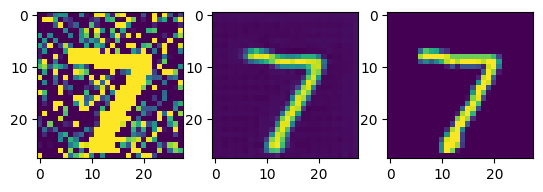

In [16]:
# 모델 성능 평가
model.cpu()
with torch.no_grad():
  #학습완료된 가중치 불러오기
  model.load_state_dict(torch.load('./CAE.pth',map_location=device))
  img = test_data.data[0]
  gaussian = gaussian_noise(img)

  # 모델의 입력 모양에 맞춰 채널 차원 추가
  input = torch.unsqueeze(gaussian,dim=0)
  input.type(torch.FloatTensor) #가중치와 입력의 데이터 타입 맞춤
  input.to(device)
  input = torch.unsqueeze(input,dim=0)  # 배치크기 1을 위한 배치 차원 추가

  plt.subplot(1,3,1)
  plt.imshow(torch.squeeze(gaussian))
  plt.subplot(1,3,2)
  plt.imshow(torch.squeeze(model(input)))
  plt.subplot(1,3,3)
  plt.imshow(torch.squeeze(img))
  plt.show()